In [55]:
import pandas as pd
import numpy as np
import os
import math

%matplotlib inline
import matplotlib.pyplot as plt

In [56]:
d15 = pd.read_csv('HCPCS_2015.csv')[['HCPCS Description', 'Place of Service', 'HCPCS Drug Indicator', 'Average Submitted Charge Amount']]
d16 = pd.read_csv('HCPCS_2016.csv')[['HCPCS Description', 'Place of Service', 'HCPCS Drug Indicator', 'Average Submitted Charge Amount']]
d17 = pd.read_csv('HCPCS_2017.csv')[['HCPCS Description', 'Place of Service', 'HCPCS Drug Indicator', 'Average Submitted Charge Amount']]

d16.head()

,HCPCS Description,Place of Service,HCPCS Drug Indicator,Average Submitted Charge Amount
0,Creation of eye fluid drainage tracts in iris ...,F,N,1120.83
1,Repair of nerve using vein graft,F,N,2674.01
2,Chemical treatment of acne,F,N,137.89
3,"Subsequent observation care, typically 25 minu...",F,N,159.32
4,Repair of esophageal sphincter using an endosc...,F,N,5885.87


In [57]:
d15 = d15.loc[(d15['Place of Service'] == 'F') & (d15['HCPCS Drug Indicator'] == 'N')][['HCPCS Description', 'Place of Service', 'Average Submitted Charge Amount']]
d16 = d16.loc[(d16['Place of Service'] == 'F') & (d16['HCPCS Drug Indicator'] == 'N')][['HCPCS Description', 'Place of Service', 'Average Submitted Charge Amount']]
d17 = d17.loc[(d17['Place of Service'] == 'F') & (d17['HCPCS Drug Indicator'] == 'N')][['HCPCS Description', 'Place of Service', 'Average Submitted Charge Amount']]

In [58]:
manifest = pd.concat([d15, d16, d17])

manifest['description'] = manifest.pop('HCPCS Description')
manifest['place'] = manifest.pop('Place of Service')
manifest['charged_amount'] = manifest.pop('Average Submitted Charge Amount')

# shuffle dataframe
manifest = manifest.sample(frac=1).reset_index(drop=True)

manifest.head()

,description,place,charged_amount
0,Bypass of diseased or blocked artery (upper le...,F,4327.11
1,Laser destruction of anal growths,F,1082.08
2,Injection of X-ray contrast material for ultra...,F,156.74
3,Natriuretic peptide (heart and blood vessel pr...,F,98.41
4,"Screening papanicolaou smear, cervical or vagi...",F,89.22


In [59]:
manifest.describe()

,charged_amount
count,14081.000000
mean,2134.048140
std,2274.369406
min,1.150000
25%,428.610000
50%,1580.830000
75%,3017.540000
max,31037.000000


(array([3106., 1148., 1049., 1028.,  908.,  947.,  898.,  841.,  641.,
        582.,  488.,  379.,  312.,  247.,  198.,  178.,  136.,  130.,
        108.,   81.,   67.,   75.,   51.,   38.,   41.,   25.,   28.,
         21.,   25.,   23.]), array([   23.84      ,   365.35833333,   706.87666667,  1048.395     ,
        1389.91333333,  1731.43166667,  2072.95      ,  2414.46833333,
        2755.98666667,  3097.505     ,  3439.02333333,  3780.54166667,
        4122.06      ,  4463.57833333,  4805.09666667,  5146.615     ,
        5488.13333333,  5829.65166667,  6171.17      ,  6512.68833333,
        6854.20666667,  7195.725     ,  7537.24333333,  7878.76166667,
        8220.28      ,  8561.79833333,  8903.31666667,  9244.835     ,
        9586.35333333,  9927.87166667, 10269.39      ]), <a list of 30 Patch objects>)


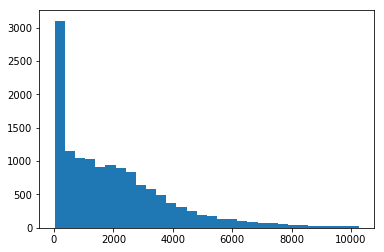

In [60]:
manifest = manifest[(manifest.iloc[:,2] < manifest.iloc[:,2].quantile(.99))&(manifest.iloc[:,2] > manifest.iloc[:,2].quantile(.01))]

# plot Average Submitted Charge Amount
fig, axs = plt.subplots(1,1, sharey=True)
print(axs.hist(manifest['charged_amount'], bins=30))

In [61]:
# set 6 different categries
labels = ['Very-Low', 'Low', 'Moderate-Low', 'Moderate-High', 'High', 'Very-High']
charged_amount_divide = [manifest.iloc[:,2].min(), manifest.iloc[:,2].quantile(.1), manifest.iloc[:,2].quantile(.3), manifest.iloc[:,2].quantile(.5), manifest.iloc[:,2].quantile(.7), manifest.iloc[:,2].quantile(.9), manifest.iloc[:,2].max()]

print(f'Very-Low range is {charged_amount_divide[0]:.1f}, {charged_amount_divide[1]:.1f})')
print(f'Low range is [{charged_amount_divide[1]:.1f}, {charged_amount_divide[2]:.1f})')
print(f'Moderate-Low range is [{charged_amount_divide[2]:.1f}, {charged_amount_divide[3]:.1f})')
print(f'Moderate-High range is [{charged_amount_divide[3]:.1f}, {charged_amount_divide[4]:.1f})')
print(f'High range is [{charged_amount_divide[4]:.1f}, {charged_amount_divide[5]:.1f})')
print(f'Very-High range is [{charged_amount_divide[5]:.1f}, {charged_amount_divide[6]:.1f})')

Very-Low range is 23.8, 121.9)
Low range is [121.9, 660.3)
Moderate-Low range is [660.3, 1580.8)
Moderate-High range is [1580.8, 2647.1)
High range is [2647.1, 4573.3)
Very-High range is [4573.3, 10269.4)


In [62]:
def bucket_amt(amount):
    for i, amt in enumerate(charged_amount_divide):
        if amount < amt:
            return labels[i - 1]

manifest['label'] = manifest.charged_amount.apply(lambda x: bucket_amt(x))
manifest.label.value_counts()

Low              2760
Moderate-High    2760
High             2760
Moderate-Low     2759
Very-Low         1380
Very-High        1379
Name: label, dtype: int64

In [63]:
train_split = 0.6 
valid_split = 0.15
test_split = 0.25

train_samples_per_label = dict(train_split*(manifest.label.value_counts()))
valid_samples_per_label = dict(valid_split*(manifest.label.value_counts()))
test_samples_per_label = dict(test_split*(manifest.label.value_counts()))

train_samples_per_label

{'Low': 1656.0,
 'Moderate-High': 1656.0,
 'High': 1656.0,
 'Moderate-Low': 1655.3999999999999,
 'Very-Low': 828.0,
 'Very-High': 827.4}

In [64]:
label_samples = dict()
train_df, valid_df, test_df = pd.DataFrame(columns=manifest.columns), pd.DataFrame(columns=manifest.columns), pd.DataFrame(columns=manifest.columns)

for label in labels:
    label_samples[label] = manifest.loc[manifest.label == label]
    train_cutoff = math.floor(train_samples_per_label[label])
    valid_cutoff = math.floor(valid_samples_per_label[label])
    test_cutoff = math.floor(test_samples_per_label[label])
    
    train_df = pd.concat([train_df, label_samples[label].iloc[:train_cutoff]])
    valid_df = pd.concat([valid_df, label_samples[label].iloc[train_cutoff:train_cutoff + valid_cutoff]])
    test_df = pd.concat([test_df, label_samples[label].iloc[-test_cutoff:]])

len(train_df), len(valid_df), len(test_df), len(manifest)

(8278, 2068, 3448, 13799)

In [74]:
label_map = dict(map(reversed, enumerate(labels)))

train_df['label_id'] = train_df['label'].apply(lambda x: label_map.get(x))
valid_df['label_id'] = valid_df['label'].apply(lambda x: label_map.get(x))
test_df['label_id'] = test_df['label'].apply(lambda x: label_map.get(x))

In [75]:
with open('labels.txt', 'w') as l:
    for label in labels: 
        l.write(label + '\n')

In [76]:
train_df.to_csv('train.csv')
valid_df.to_csv('valid.csv')
test_df.to_csv('test.csv')